# Convert each 2D slice using the Radon Transform

In [1]:
import os
from os import path

import numpy as np
from matplotlib import pyplot as plt
from skimage import transform
import pydicom
from ipywidgets import interact

import tensorflow as tf
import tensorflow_probability as tfp

from error_propagation_radon_transform import utils

# Prototype

In [4]:
ds = pydicom.read_file('../Data/Train_Sets/CT/1/DICOM_anon/i0000,0000b.dcm')

In [5]:
ds.LargestImagePixelValue

2362

In [6]:
ConstPixelDims = (int(ds.Rows), int(ds.Columns))
ConstPixelSpacing = (float(ds.PixelSpacing[0]), float(ds.PixelSpacing[1]), float(ds.SliceThickness))

print(ConstPixelDims)
print(ConstPixelSpacing)

(512, 512)
(0.687671, 0.687671, 3.0)


In [7]:
ArrayDicom = np.zeros(ConstPixelDims, dtype=ds.pixel_array.dtype)
ArrayDicom[:,:] = ds.pixel_array
# scale down
ArrayDicom = ArrayDicom[::8,::8]
# normalize
ArrayDicom = ArrayDicom / ArrayDicom.max() * 255

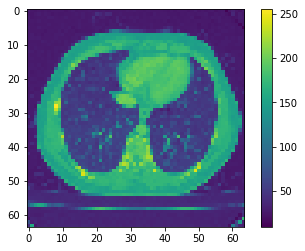

In [8]:
plt.imshow(ArrayDicom)
plt.colorbar()
plt.show()

In [7]:
theta = np.linspace(0., 180., max(ArrayDicom.shape), endpoint=False)
sinogram = transform.radon(ArrayDicom, theta=theta)

reconstructed = transform.iradon(sinogram, theta=theta, filter_name='ramp')

/home/vik/Programme/anaconda3/envs/ai-cpu/lib/python3.8/site-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


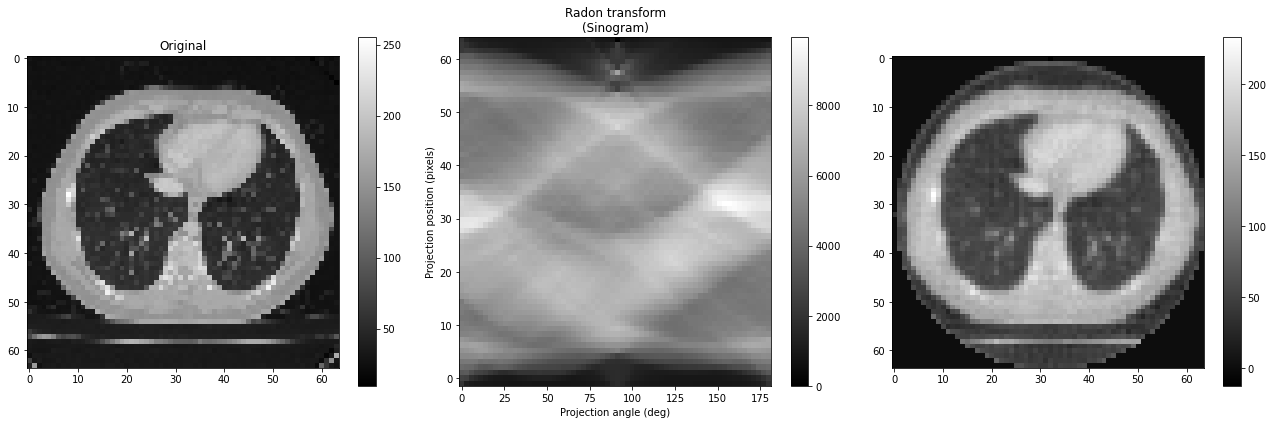

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.set_title('Original')
kid = ax1.imshow(ArrayDicom, cmap='gray')

plt.colorbar(kid, ax=ax1)

dx, dy = 0.5 * 180.0 / max(ArrayDicom.shape), 0.5 / sinogram.shape[0]
ax2.set_title('Radon transform\n(Sinogram)')
ax2.set_xlabel('Projection angle (deg)')
ax2.set_ylabel('Projection position (pixels)')
sin = ax2.imshow(sinogram, cmap='gray', extent=(-dx, 180 + dx, -dx, sinogram.shape[0] + dy), aspect='auto')

plt.colorbar(sin, ax=ax2)

re = ax3.imshow(reconstructed, cmap='gray')
plt.colorbar(re, ax=ax3)

fig.tight_layout()
plt.show()

# Bulk conversion

## Normalize
The values of the images should be between 0 and 255, but are from 0 to 2000 or so. So we need to find the maximal density and normalize all by that maximum.

In [9]:
parentFolder = '../Data/Train_Sets/CT/1/DICOM_anon'
fileList = os.listdir(parentFolder)

In [10]:
supremum = 0
for f in fileList:
    ds = pydicom.read_file(path.join(parentFolder, f))
    supremum = max(supremum, ds.LargestImagePixelValue)

print(supremum)

2464


In [11]:
def _get_fourier_filter(size, filter_name):
    n = np.concatenate((np.arange(1, size / 2 + 1, 2, dtype=int),
                       np.arange(size / 2 - 1, 0, -2, dtype=int)))
    f = np.zeros(size)
    # ramp filter
    f[0] = 0.25
    f[1::2] = -1 / (np.pi * n) ** 2
    
    fourier_filter = 2 * np.real(np.fft.fft(f))
    if filter_name == 'ramp':
        pass
    elif filter_name == 'shepp-logan':
        # start from first element to avoid divide by zero
        omega = np.pi * np.fft.fftfreq(size)[1:]
        fourier_filter[1:] *= np.sin(omega) / omega
    elif filter_name == 'cosine':
        freq = np.linspace(0, np.pi, size, endpoint=False)
        cosine_filter = np.fft.fftshift(np.sin(freq))
        fourier_filter *= cosine_filter
    elif filter_name == 'hamming':
        fourier_filter *= np.fft.fftshift(np.hamming(size))
    elif filter_name == 'hann':
        fourier_filter *= np.fft.fftshift(np.hanning(size))
    elif filter_name is None:
        fourier_filter[:] = 1
        
    return fourier_filter[:, np.newaxis]

def _sinogram_circle_to_square(sinogram):
    diagonal = int(np.ceil(np.sqrt(2) * sinogram.shape[0]))
    pad = diagonal - sinogram.shape[0]
    old_center = sinogram.shape[0] // 2
    new_center = diagonal // 2
    pad_before = new_center - old_center
    pad_width = ((pad_before, pad - pad_before), (0, 0))
    return np.pad(sinogram, pad_width, mode='constant', constant_values=0)

def inverse_radon(sinogram, theta, reconstruction_shape, filter_name):
    radon_image = tf.Variable(sinogram, dtype=tf.complex64)
    angles_count = len(theta)
    img_shape = radon_image.shape[0]
    output_size = img_shape

    fourier_filter = _get_fourier_filter(img_shape, filter_name)
    projection = tf.transpose(tf.signal.fft(tf.transpose(radon_image))) * fourier_filter
    radon_image_filtered = tf.math.real(tf.transpose(tf.signal.ifft(tf.transpose(projection)))[:img_shape, :])

    reconstructed = tf.zeros(reconstruction_shape)
    radius = output_size // 2
    xpr, ypr = np.mgrid[:output_size, :output_size] - radius
    x = np.arange(img_shape, dtype=np.float32) - img_shape // 2

    for col, angle in zip(tf.transpose(radon_image_filtered), np.deg2rad(theta)):
        t = np.asarray(ypr * tf.cos(angle) - xpr * tf.sin(angle), dtype=np.float32)
        interpolant = tfp.math.interp_regular_1d_grid(t, x[0], x[-1], col, fill_value=0)
        reconstructed += interpolant

    kidney_reconstructed = reconstructed * np.pi / (2 * angles_count)

    return kidney_reconstructed

In [12]:
if not path.exists('../Data/Train_Sets/CT/1/numpy'):
    os.mkdir('../Data/Train_Sets/CT/1/numpy')

# transform
for f in fileList:
    identifier = int(f[3:5])
    ds = pydicom.read_file(path.join(parentFolder, f))
    
    ArrayDicom = np.zeros(ConstPixelDims, dtype=ds.pixel_array.dtype)
    ArrayDicom[:,:] = ds.pixel_array
    # scale down
    ArrayDicom = ArrayDicom[::8,::8]
    # normalize
    ArrayDicom = ArrayDicom / supremum * 255
    
    sinogram = transform.radon(ArrayDicom, theta=theta)
    
    reconstructed = inverse_radon(sinogram, theta, ArrayDicom.shape, 'ramp')

    #reconstructed = transform.iradon(sinogram, theta=theta, filter_name='ramp')
    
    np.save('../Data/Train_Sets/CT/1/numpy/reconstructed-{:02d}.npy'.format(identifier), reconstructed)
    print('../Data/Train_Sets/CT/1/numpy/reconstructed-{:02d}.npy'.format(identifier))

../Data/Train_Sets/CT/1/numpy/reconstructed-61.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-95.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-65.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-75.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-53.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-17.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-52.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-32.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-72.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-18.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-91.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-19.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-83.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-73.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-45.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-76.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-85.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-70.npy
../Data/Train_Sets/CT/1/numpy/reconstructed-51.npy
../Data/Train_Sets/CT/1/numpy/r

# Merging into 3D

## The reconstructed data

In [9]:
parentFolder = '../Data/Train_Sets/CT/1/numpy/'
fileList = os.listdir(parentFolder)
n = len(fileList)
resolution = np.array(ConstPixelDims) // 8

reconstructed3D = np.empty((*resolution, n))
for idx in range(n):
    dataSlice = np.load(path.join(parentFolder, 'reconstructed-{:02d}.npy'.format(idx)))
    reconstructed3D[:,:,idx] = dataSlice
    print(idx/n * 100, '%', end='\r')
    
np.save('../Data/inverse_Radon_Transform/reconstructed-64x64x96.npy', reconstructed3D)

In [10]:
print(n)

96


In [15]:
@interact(idx=(0,n-1,1))
def show_slices(idx=0):
    plt.figure(figsize=(18,6))
    plt.imshow(reconstructed3D[:,:,idx], vmin=0, vmax=255, cmap='gray')
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=0, description='idx', max=95), Output()), _dom_classes=('widget-interact…

## The standard deviation

In [15]:
std_slice = np.load('../Data/inverse_Radon_Transform/std_64x64_expdecay246.4x10.npy')

std_3d = np.tile(std_slice, n).reshape((64,n,64)).transpose([0,2,1])
print(std_3d.shape)

np.save('../Data/inverse_Radon_Transform/std3d_64x64_expdecay246.4x10.npy', std_3d)

(64, 64, 96)


In [14]:
@interact(idx=(0,n-1,1))
def show_slices(idx=0):
    plt.figure(figsize=(18,6))
    plt.imshow(std_3d[:,:,idx])
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=0, description='idx', max=95), Output()), _dom_classes=('widget-interact…